In [1]:
#math
import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
num_true = 7
num_bidders1 = 10
num_bidders2 = 2
mu = 3
sigma = 2


def gen_data(values):
    nobs = 500
    
    #parameters
    
    
    min_bids =num_true
    max_bids =num_true
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i =  np.sort(bids_i, axis=1)
        bids_i =  bids_i[:,-2]
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids,bidders,nobs


values_distr =stats.logistic(loc=mu, scale=sigma)
bids,i,nobs = gen_data(values_distr)
print(bids.shape)
print(bids[i == num_true].mean())

(500,)
5.556029949962365


In [3]:
scipy.special.factorial([4,3])

array([24.,  6.])

In [4]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.logistic, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglikeobs(self, params):
        bids = self.endog
        i = self.exog[:,0]
        cdf = self.values_distr.cdf(bids,loc=params[0],scale=max(params[1],1e-5))
        pdf = self.values_distr.pdf(bids,loc=params[0],scale=max(params[1],1e-5))
        factorial = scipy.special.factorial(i)/scipy.special.factorial(i-2)  
        
        order_cdf = factorial*pdf*cdf**(i-2)*(1-cdf) #np.log(i) + np.log(cdf) + (i-1)*np.log((1-cdf)) #second highest order statistic
        return np.log(order_cdf)
    

np.random.seed()
yn,xn,nobs = gen_data(stats.logistic(loc=mu, scale=sigma))
model = Auction(yn,xn)
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -981.03
Model:                        Auction   AIC:                             1964.
Method:            Maximum Likelihood   BIC:                             1968.
Date:                Wed, 17 Mar 2021                                         
Time:                        19:12:09                                         
No. Observations:                 500                                         
Df Residuals:                     499                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9326      0.097     30.183      0.000       2.742       3.123
par0           1.9322      0.066     29.461      0.000       1.804       2.061
==============================================================================
"""

In [5]:
np.random.seed()
yn,xn,nobs = gen_data(stats.logistic(loc=mu, scale=sigma))

#fit normal values
model1 = Auction(yn,num_bidders1*np.ones(xn.shape[0]))
model_fit1 = model1.fit(start_params=[mu,sigma],disp=False)

#fit logistic values
model2 = Auction(yn,num_bidders2*np.ones(xn.shape[0]))
model_fit2 = model2.fit(start_params=[mu,sigma],disp=False)


print(model_fit1.summary())
print(model_fit2.summary())

print( (model1.loglikeobs(model_fit1.params) - model2.loglikeobs(model_fit2.params) ).sum() )
print( (model1.loglikeobs(model_fit1.params) - model2.loglikeobs(model_fit2.params) ).var() )

                               Auction Results                                
Dep. Variable:                      y   Log-Likelihood:                -991.38
Model:                        Auction   AIC:                             1985.
Method:            Maximum Likelihood   BIC:                             1989.
Date:                Wed, 17 Mar 2021                                         
Time:                        19:12:14                                         
No. Observations:                 500                                         
Df Residuals:                     499                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9450      0.120     16.263      0.000       1.711       2.179
par0           2.0663      0.070     29.609      0.0

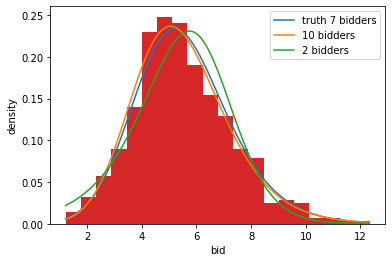

In [6]:
#create plot for true
support_y = np.arange(yn.min(),yn.max(),.1)
support_x = num_true*np.ones(len(support_y))
true_model = Auction(support_y,support_x)
true_model_y = np.exp(true_model.loglikeobs([mu,sigma]))
plt.plot(support_y, true_model_y ,label="truth %s bidders"%num_true)

#create plot for bidders1
normal1_model = Auction(support_y,support_x*num_bidders1/num_true)
fit_normal1_y = np.exp(normal1_model.loglikeobs(model_fit1.params))
plt.plot(support_y, fit_normal1_y ,label="%s bidders"%num_bidders1)

#create plot for bidders2
normal2_model = Auction(support_y,support_x*num_bidders2/num_true)
fit_normal2_y = np.exp(normal2_model.loglikeobs(model_fit2.params))
plt.plot(support_y, fit_normal2_y ,label="%s bidders"%num_bidders2)

plt.legend()
plt.hist(yn,bins=20,density=True)

plt.ylabel("density")
plt.xlabel("bid")
#plt.ylim((0.,100.))
plt.savefig('../figs/auction_main.png')
#plt.xlim((-.25,0.75))
#plt.savefig('figs/nonnested_zoom')
plt.show()

plt.show()
